# **INFORMASI DATASET**
## Latar Belakang

Dalam dunia bisnis ritel, pemahaman terhadap perilaku pelanggan menjadi salah satu faktor krusial dalam menentukan strategi pemasaran, peningkatan layanan, serta pengambilan keputusan berbasis data. Salah satu pendekatan yang umum digunakan untuk memahami perilaku pelanggan adalah melalui segmentasi, yaitu proses pengelompokan pelanggan ke dalam beberapa segmen atau kelompok berdasarkan karakteristik tertentu.

Dengan menerapkan metode **unsupervised learning**, khususnya **clustering**, proyek ini bertujuan untuk membentuk segmentasi pelanggan yang merepresentasikan pola-pola pembelian yang serupa. Hasil segmentasi ini diharapkan dapat memberikan insight yang bernilai bagi pihak manajemen, khususnya dalam menyusun strategi promosi yang lebih tepat sasaran, mengembangkan program loyalitas, serta mengoptimalkan layanan pelanggan.

# **1. Import Library**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

import joblib

# **2. Memuat Dataset**


In [2]:
url='https://drive.google.com/uc?id=1gnLO9qvEPqv1uBt1928AcsCmdvzqjC5m'
df = pd.read_csv(url)

In [3]:
# Tampilkan 5 baris pertama dengan function head.

print(df.head())

  TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0         70.0             Doctor                 81.0 

In [4]:
# Tinjau jumlah baris kolom dan jenis data dalam dataset dengan info.

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537 entries, 0 to 2536
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2508 non-null   object 
 1   AccountID                2516 non-null   object 
 2   TransactionAmount        2511 non-null   float64
 3   TransactionDate          2509 non-null   object 
 4   TransactionType          2507 non-null   object 
 5   Location                 2507 non-null   object 
 6   DeviceID                 2507 non-null   object 
 7   IP Address               2517 non-null   object 
 8   MerchantID               2514 non-null   object 
 9   Channel                  2510 non-null   object 
 10  CustomerAge              2519 non-null   float64
 11  CustomerOccupation       2514 non-null   object 
 12  TransactionDuration      2511 non-null   float64
 13  LoginAttempts            2516 non-null   float64
 14  AccountBalance          

In [5]:
# Menampilkan statistik deskriptif dataset dengan menjalankan describe

print(df.describe())

       TransactionAmount  CustomerAge  TransactionDuration  LoginAttempts  \
count        2511.000000  2519.000000          2511.000000    2516.000000   
mean          297.656468    44.678444           119.422939       1.121622   
std           292.230367    17.837359            70.078513       0.594469   
min             0.260000    18.000000            10.000000       1.000000   
25%            81.310000    27.000000            63.000000       1.000000   
50%           211.360000    45.000000           112.000000       1.000000   
75%           413.105000    59.000000           161.000000       1.000000   
max          1919.110000    80.000000           300.000000       5.000000   

       AccountBalance  
count     2510.000000  
mean      5113.438124  
std       3897.975861  
min        101.250000  
25%       1504.727500  
50%       4734.110000  
75%       7672.687500  
max      14977.990000  


Memuat Dataset dan Melakukan Exploratory Data Analysis (EDA)




 Korelasi antar fitur numerik:


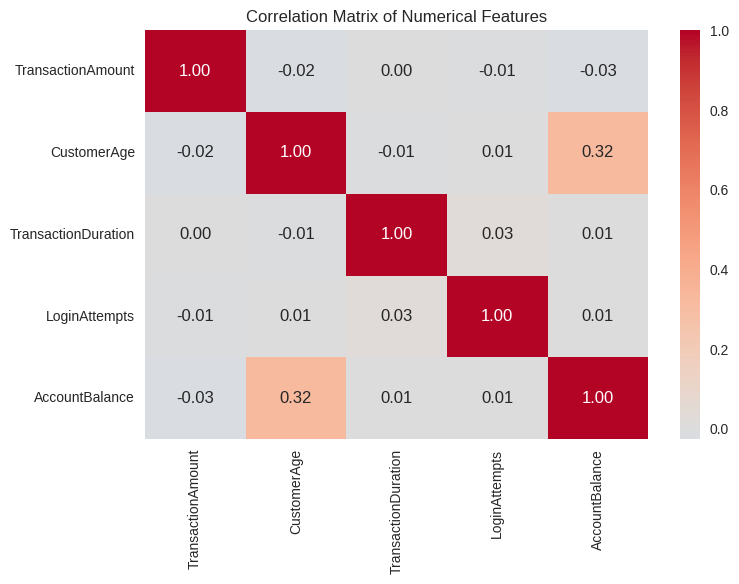

In [6]:
# Menampilkan korelasi antar fitur (Opsional Skilled 1)

print("\n Korelasi antar fitur numerik:")
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_cols].corr()

# Visualisasi correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

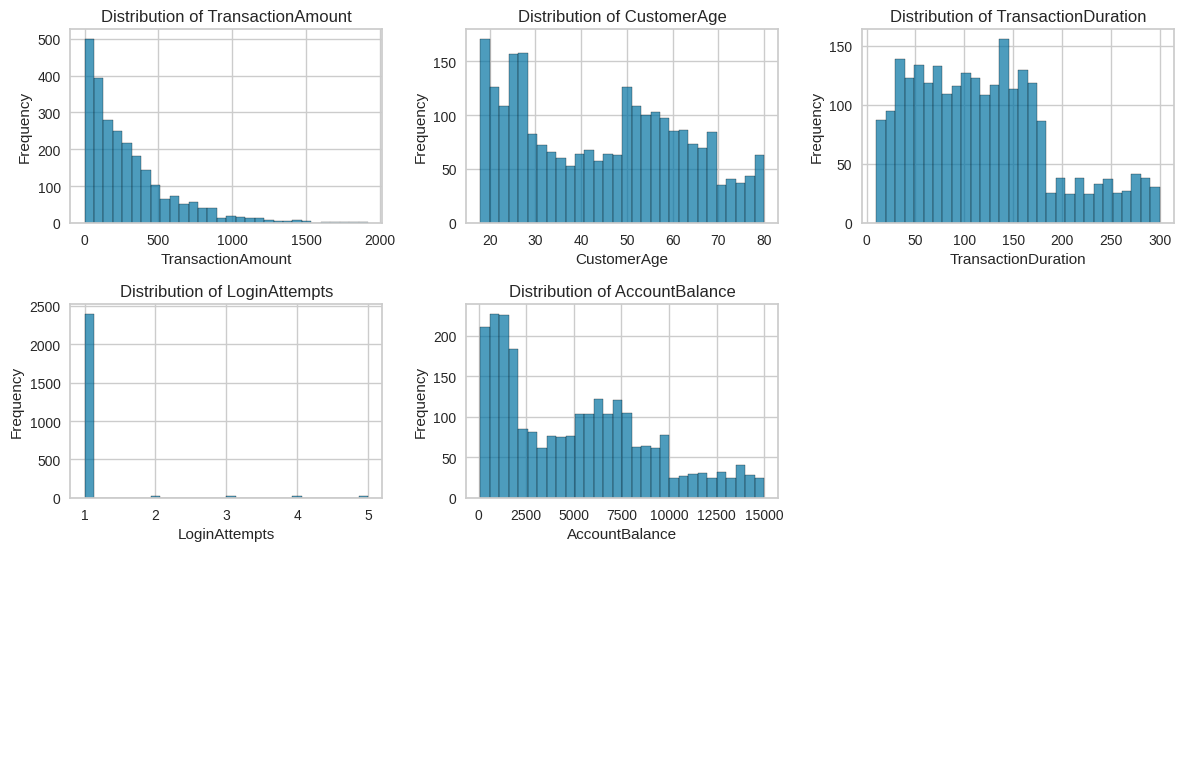

In [7]:
# Menampilkan histogram untuk semua kolom numerik (Opsional Skilled 1)

numerical_cols = df.select_dtypes(include=[np.number]).columns

fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols[:9]):
    axes[idx].hist(df[col], bins=30, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

# Hide empty subplots
for idx in range(len(numerical_cols), 9):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# **3. Pembersihan dan Pra Pemrosesan Data**

Melakukan **Pembersihan Dataset** untuk menjadikan dataset mudah diintepretasi dan bisa dilatih.

1. **Mengecek dataset** menggunakan isnull().sum() dan duplicated().sum().
2. Melakukan feature scaling menggunakan `MinMaxScaler()` atau `StandardScalar()` untuk fitur numerik.
3. Melakukan feature encoding menggunakan `LabelEncoder()` untuk fitur kategorikal.
4. Melakukan drop pada kolom id.



In [8]:
# Mengecek dataset menggunakan isnull().sum()

print("\nMissing values before handling:")
print(df.isnull().sum())


Missing values before handling:
TransactionID              29
AccountID                  21
TransactionAmount          26
TransactionDate            28
TransactionType            30
Location                   30
DeviceID                   30
IP Address                 20
MerchantID                 23
Channel                    27
CustomerAge                18
CustomerOccupation         23
TransactionDuration        26
LoginAttempts              21
AccountBalance             27
PreviousTransactionDate    24
dtype: int64


In [9]:
# Mengecek dataset menggunakan duplicated().sum()

print("\nDuplicate rows before handling:")
print(df.duplicated().sum())


Duplicate rows before handling:
21


In [11]:
# Melakukan feature scaling menggunakan MinMaxScaler() atau StandardScalar() untuk fitur numerik.
# Pastikan kamu menggunakan function head setelah melalukan scaling.

# Buat salinan DataFrame untuk diproses
df_processed = df.copy()

# Identifikasi kolom numerik yang akan di-scaling berdasarkan output df.columns
numerical_cols = ['TransactionAmount', 'CustomerAge', 'AccountBalance', 'TransactionDuration', 'LoginAttempts']

print(f"Kolom numerik yang akan di-scaling: {numerical_cols}")

Kolom numerik yang akan di-scaling: ['TransactionAmount', 'CustomerAge', 'AccountBalance', 'TransactionDuration', 'LoginAttempts']


In [12]:
# Menggunakan MinMaxScaler
scaler = MinMaxScaler()
df_processed[numerical_cols] = scaler.fit_transform(df_processed[numerical_cols])

print("\nFeature scaling selesai! Menampilkan hasil dengan head():")
print(df_processed[numerical_cols].head())



Feature scaling selesai! Menampilkan hasil dengan head():
   TransactionAmount  CustomerAge  AccountBalance  TransactionDuration  \
0           0.007207     0.838710        0.336832             0.244828   
1           0.195940     0.806452        0.918055             0.451724   
2           0.065680     0.016129        0.068637             0.158621   
3           0.096016     0.129032        0.569198             0.051724   
4           0.006874          NaN        0.492591             0.648276   

   LoginAttempts  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


In [13]:
# Melakukan drop pada kolom yang memiliki keterangan id dan IP Address
id_columns = ['TransactionID', 'AccountID', 'DeviceID', 'IP Address', 'MerchantID']
print(f"Kolom yang akan di-drop: {id_columns}")

Kolom yang akan di-drop: ['TransactionID', 'AccountID', 'DeviceID', 'IP Address', 'MerchantID']


In [14]:
df_processed = df_processed.drop(columns=id_columns)
print(f"\n Kolom berhasil di-drop! Shape dataset sekarang: {df_processed.shape}")
print("Kolom yang tersisa:")
print(df_processed.columns.tolist())


 Kolom berhasil di-drop! Shape dataset sekarang: (2537, 11)
Kolom yang tersisa:
['TransactionAmount', 'TransactionDate', 'TransactionType', 'Location', 'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate']


In [15]:
# Melakukan feature encoding menggunakan LabelEncoder() untuk fitur kategorikal.

# Identifikasi kolom kategorikal
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
print(f"Kolom kategorikal yang akan di-encode: {categorical_cols}")

Kolom kategorikal yang akan di-encode: ['TransactionDate', 'TransactionType', 'Location', 'Channel', 'CustomerOccupation', 'PreviousTransactionDate']


In [16]:
# Pastikan menggunakan function head setelah melalukan encoding.

# Melakukan Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"✅ {col} berhasil di-encode")

print(f"\n✅ Feature encoding selesai! Menampilkan hasil dengan head():")
print(df_processed.head())

✅ TransactionDate berhasil di-encode
✅ TransactionType berhasil di-encode
✅ Location berhasil di-encode
✅ Channel berhasil di-encode
✅ CustomerOccupation berhasil di-encode
✅ PreviousTransactionDate berhasil di-encode

✅ Feature encoding selesai! Menampilkan hasil dengan head():
   TransactionAmount  TransactionDate  TransactionType  Location  Channel  \
0           0.007207              680                1        36        0   
1           0.195940             1178                1        15        0   
2           0.065680             1262                1        23        2   
3           0.096016              818                1        33        2   
4           0.006874             1939                0         1        2   

   CustomerAge  CustomerOccupation  TransactionDuration  LoginAttempts  \
0     0.838710                   0             0.244828            0.0   
1     0.806452                   0             0.451724            0.0   
2     0.016129                   3 

In [17]:
# Last checking gunakan columns.tolist() untuk checking seluruh fitur yang ada.
# ____.columns.tolist()

print("\n Last checking gunakan columns.tolist() untuk checking seluruh fitur yang ada:")
print(" Periksa kode di bawah ini tidak memberikan atau menguraikan cell code ini.")
eval_columns = df_processed.columns
print("eval_columns.tolist():")
print(eval_columns.tolist())


 Last checking gunakan columns.tolist() untuk checking seluruh fitur yang ada:
 Periksa kode di bawah ini tidak memberikan atau menguraikan cell code ini.
eval_columns.tolist():
['TransactionAmount', 'TransactionDate', 'TransactionType', 'Location', 'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate']


In [18]:
# Menangani data yang hilang (bisa menggunakan dropna() atau metode imputasi fillna()).

missing_after = df_processed.isnull().sum()
print("Missing values setelah preprocessing:")
print(missing_after[missing_after > 0])

if missing_after.sum() == 0:
    print("✅ Tidak ada missing values yang perlu ditangani!")
else:
    # Jika ada missing values, lakukan imputasi
    print("⚠️ Melakukan imputasi untuk missing values...")
    df_processed = df_processed.fillna(df_processed.mean())
    print("✅ Imputasi selesai!")


Missing values setelah preprocessing:
TransactionAmount      26
CustomerAge            18
TransactionDuration    26
LoginAttempts          21
AccountBalance         27
dtype: int64
⚠️ Melakukan imputasi untuk missing values...
✅ Imputasi selesai!


In [19]:
print(df_processed.isnull().sum())

TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64


In [20]:
# Menghapus data duplikat menggunakan drop_duplicates().

print("\nMenghapus data duplikat menggunakan drop_duplicates():")
before_drop = len(df_processed)
df_processed = df_processed.drop_duplicates()
after_drop = len(df_processed)
print(f"Data sebelum menghapus duplikat: {before_drop}")
print(f"Data setelah menghapus duplikat: {after_drop}")
print(f"Jumlah data duplikat yang dihapus: {before_drop - after_drop}")


Menghapus data duplikat menggunakan drop_duplicates():
Data sebelum menghapus duplikat: 2537
Data setelah menghapus duplikat: 2515
Jumlah data duplikat yang dihapus: 22


In [21]:
# Melakukan Handling Outlier Data berdasarkan jumlah outlier, apakah menggunakan metode drop atau mengisi nilai tersebut.

In [22]:
# Melakukan binning data berdasarkan kondisi rentang nilai pada fitur numerik,
# lakukan pada satu sampai dua fitur numerik.
# Silahkan lakukan encode hasil binning tersebut menggunakan LabelEncoder.

# penanganan outlier


--- Langkah 1: Visualisasi Outlier (Sebelum Penanganan) ---
Memvisualisasikan outlier untuk fitur: ['TransactionAmount', 'TransactionDate', 'TransactionType', 'Location', 'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate']


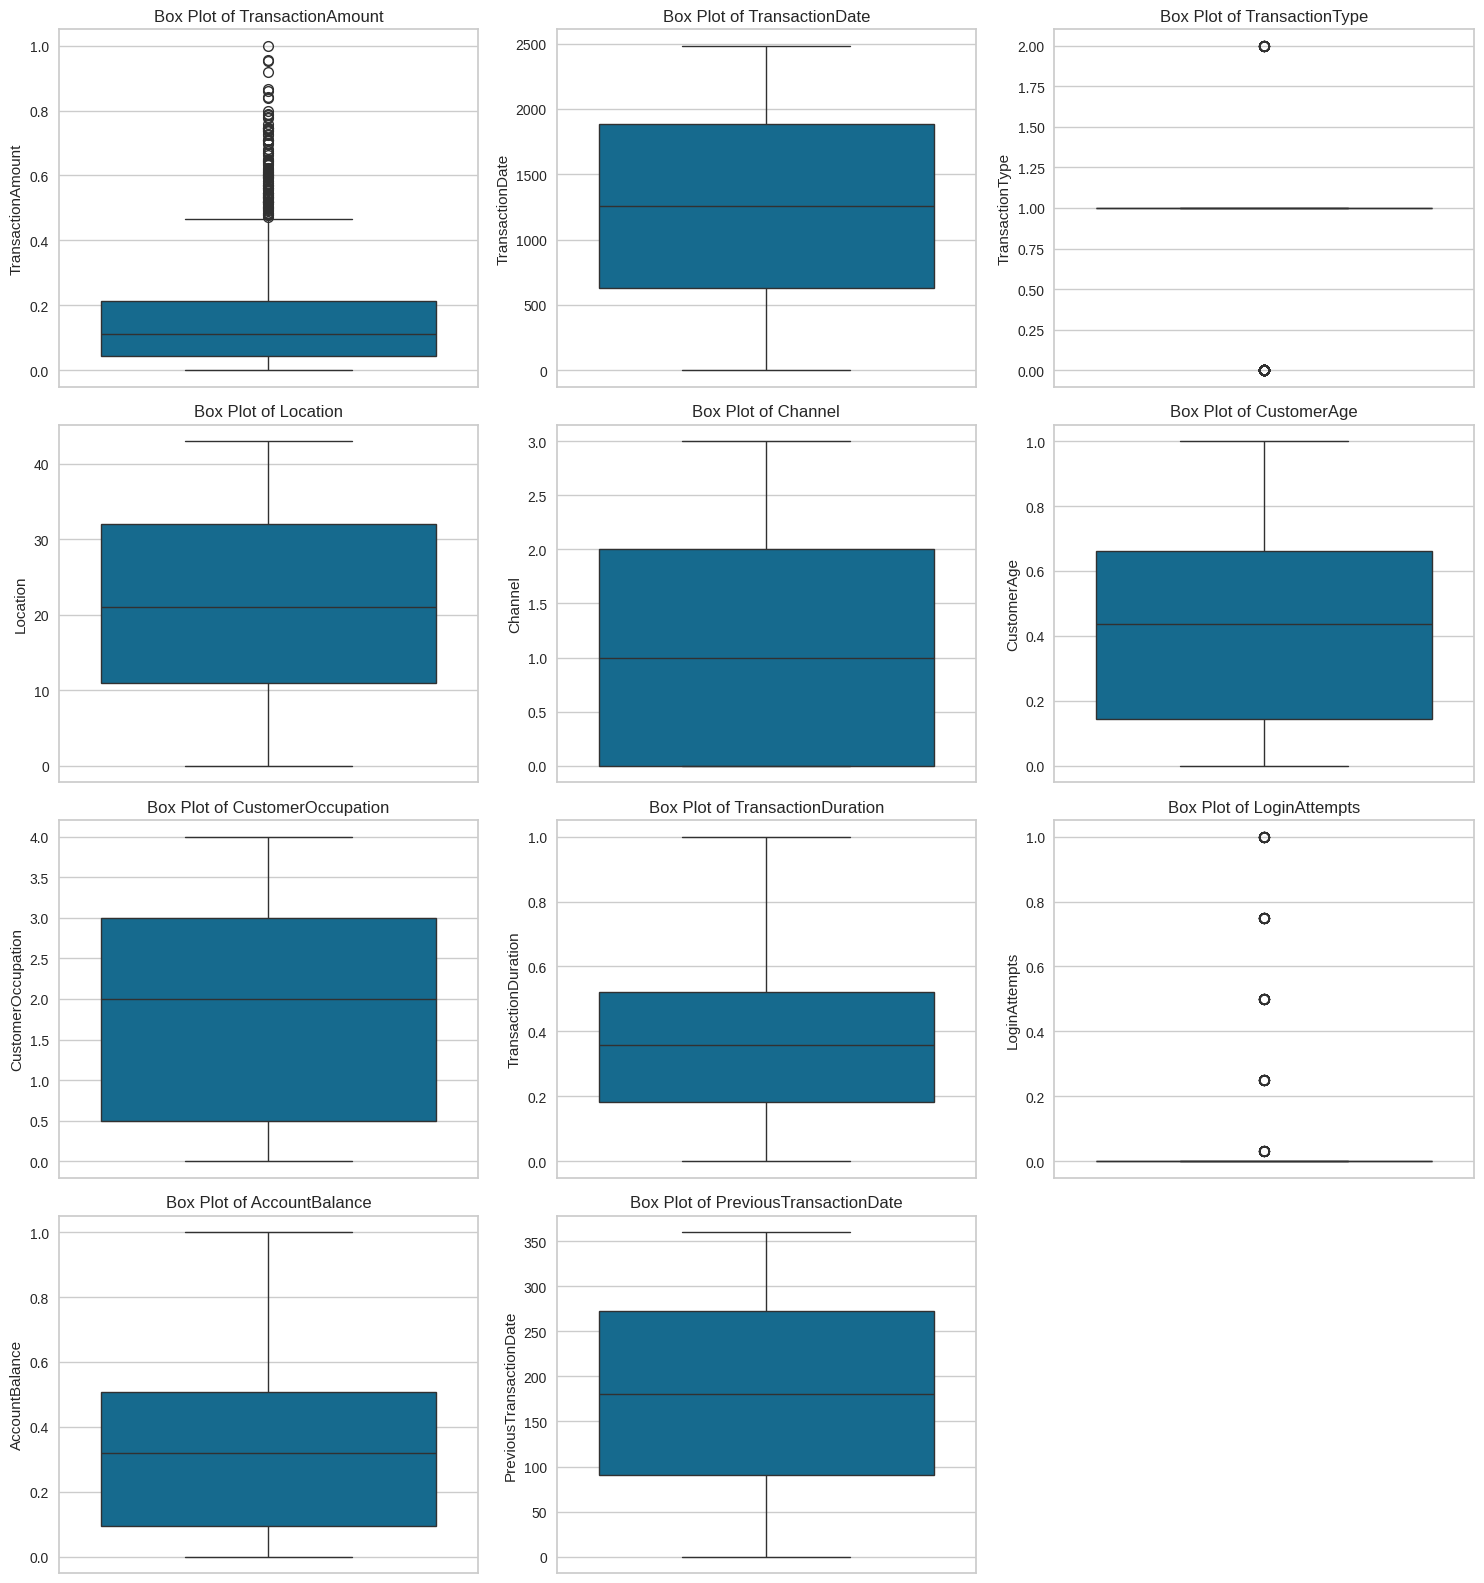

Visualisasi outlier (sebelum penanganan) selesai.


In [23]:
# --- Langkah 1: Visualisasi Outlier Menggunakan Box Plot (Sebelum Penanganan) ---

print("--- Langkah 1: Visualisasi Outlier (Sebelum Penanganan) ---")

# Identifikasi kolom numerik yang relevan setelah preprocessing
# Gunakan kolom-kolom yang sudah diskalakan
numerical_cols_scaled = df_processed.select_dtypes(include=[np.number]).columns.tolist()
# Hapus kolom 'Target' jika masih ada di sini (seharusnya sudah terpisah jika mengikuti langkah sebelumnya)
if 'Target' in numerical_cols_scaled:
    numerical_cols_scaled.remove('Target')

if not numerical_cols_scaled:
    print("Tidak ada fitur numerik yang relevan untuk visualisasi outlier.")
else:
    print(f"Memvisualisasikan outlier untuk fitur: {numerical_cols_scaled}")
    # Batasi jumlah fitur yang divisualisasikan dalam satu figure jika terlalu banyak
    n_cols = 3
    n_rows = (len(numerical_cols_scaled) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten() # Meratakan array axes agar mudah diakses

    for i, col in enumerate(numerical_cols_scaled):
        if i < len(axes):
            sns.boxplot(y=df_processed[col], ax=axes[i])
            axes[i].set_title(f'Box Plot of {col}')
            axes[i].set_ylabel(col)
        else:
            axes[i].axis('off') # Sembunyikan subplot yang kosong

    # Sembunyikan subplot yang tidak digunakan jika jumlah fitur tidak pas dengan grid
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    print("Visualisasi outlier (sebelum penanganan) selesai.")

In [24]:
# --- Langkah 2: Menangani Outlier Menggunakan Metode Capping (IQR) ---

print("\n--- Langkah 2: Menangani Outlier Menggunakan Metode Capping (IQR) ---")

# Gunakan salinan DataFrame yang sudah diproses dan diskalakan
df_processed_cleaned = df_processed.copy()

# Gunakan kembali daftar kolom numerik yang relevan
if not numerical_cols_scaled:
     print("Tidak ada fitur numerik untuk penanganan outlier.")
else:
    for col in numerical_cols_scaled:
        try:
            # Hitung IQR pada data yang diskalakan
            Q1 = df_processed_cleaned[col].quantile(0.25)
            Q3 = df_processed_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1

            # Tentukan batas atas dan bawah untuk outlier
            # Menggunakan 1.5 * IQR adalah ambang batas umum
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # capping: ganti nilai di luar batas dengan batas itu sendiri
            df_processed_cleaned[col] = df_processed_cleaned[col].clip(lower=lower_bound, upper=upper_bound)
            print(f"✅ Outlier di kolom '{col}' berhasil ditangani dengan capping.")
        except Exception as e:
            print(f"❌ Gagal menangani outlier di kolom '{col}': {e}")


print("\nDataFrame setelah penanganan outlier (beberapa baris pertama):")
print(df_processed_cleaned.head())
print("\nProses penanganan outlier selesai.")


--- Langkah 2: Menangani Outlier Menggunakan Metode Capping (IQR) ---
✅ Outlier di kolom 'TransactionAmount' berhasil ditangani dengan capping.
✅ Outlier di kolom 'TransactionDate' berhasil ditangani dengan capping.
✅ Outlier di kolom 'TransactionType' berhasil ditangani dengan capping.
✅ Outlier di kolom 'Location' berhasil ditangani dengan capping.
✅ Outlier di kolom 'Channel' berhasil ditangani dengan capping.
✅ Outlier di kolom 'CustomerAge' berhasil ditangani dengan capping.
✅ Outlier di kolom 'CustomerOccupation' berhasil ditangani dengan capping.
✅ Outlier di kolom 'TransactionDuration' berhasil ditangani dengan capping.
✅ Outlier di kolom 'LoginAttempts' berhasil ditangani dengan capping.
✅ Outlier di kolom 'AccountBalance' berhasil ditangani dengan capping.
✅ Outlier di kolom 'PreviousTransactionDate' berhasil ditangani dengan capping.

DataFrame setelah penanganan outlier (beberapa baris pertama):
   TransactionAmount  TransactionDate  TransactionType  Location  Channel  \
0


--- Langkah 3: Visualisasi Outlier (Setelah Penanganan) ---
Memvisualisasikan outlier setelah penanganan untuk fitur: ['TransactionAmount', 'TransactionDate', 'TransactionType', 'Location', 'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate']


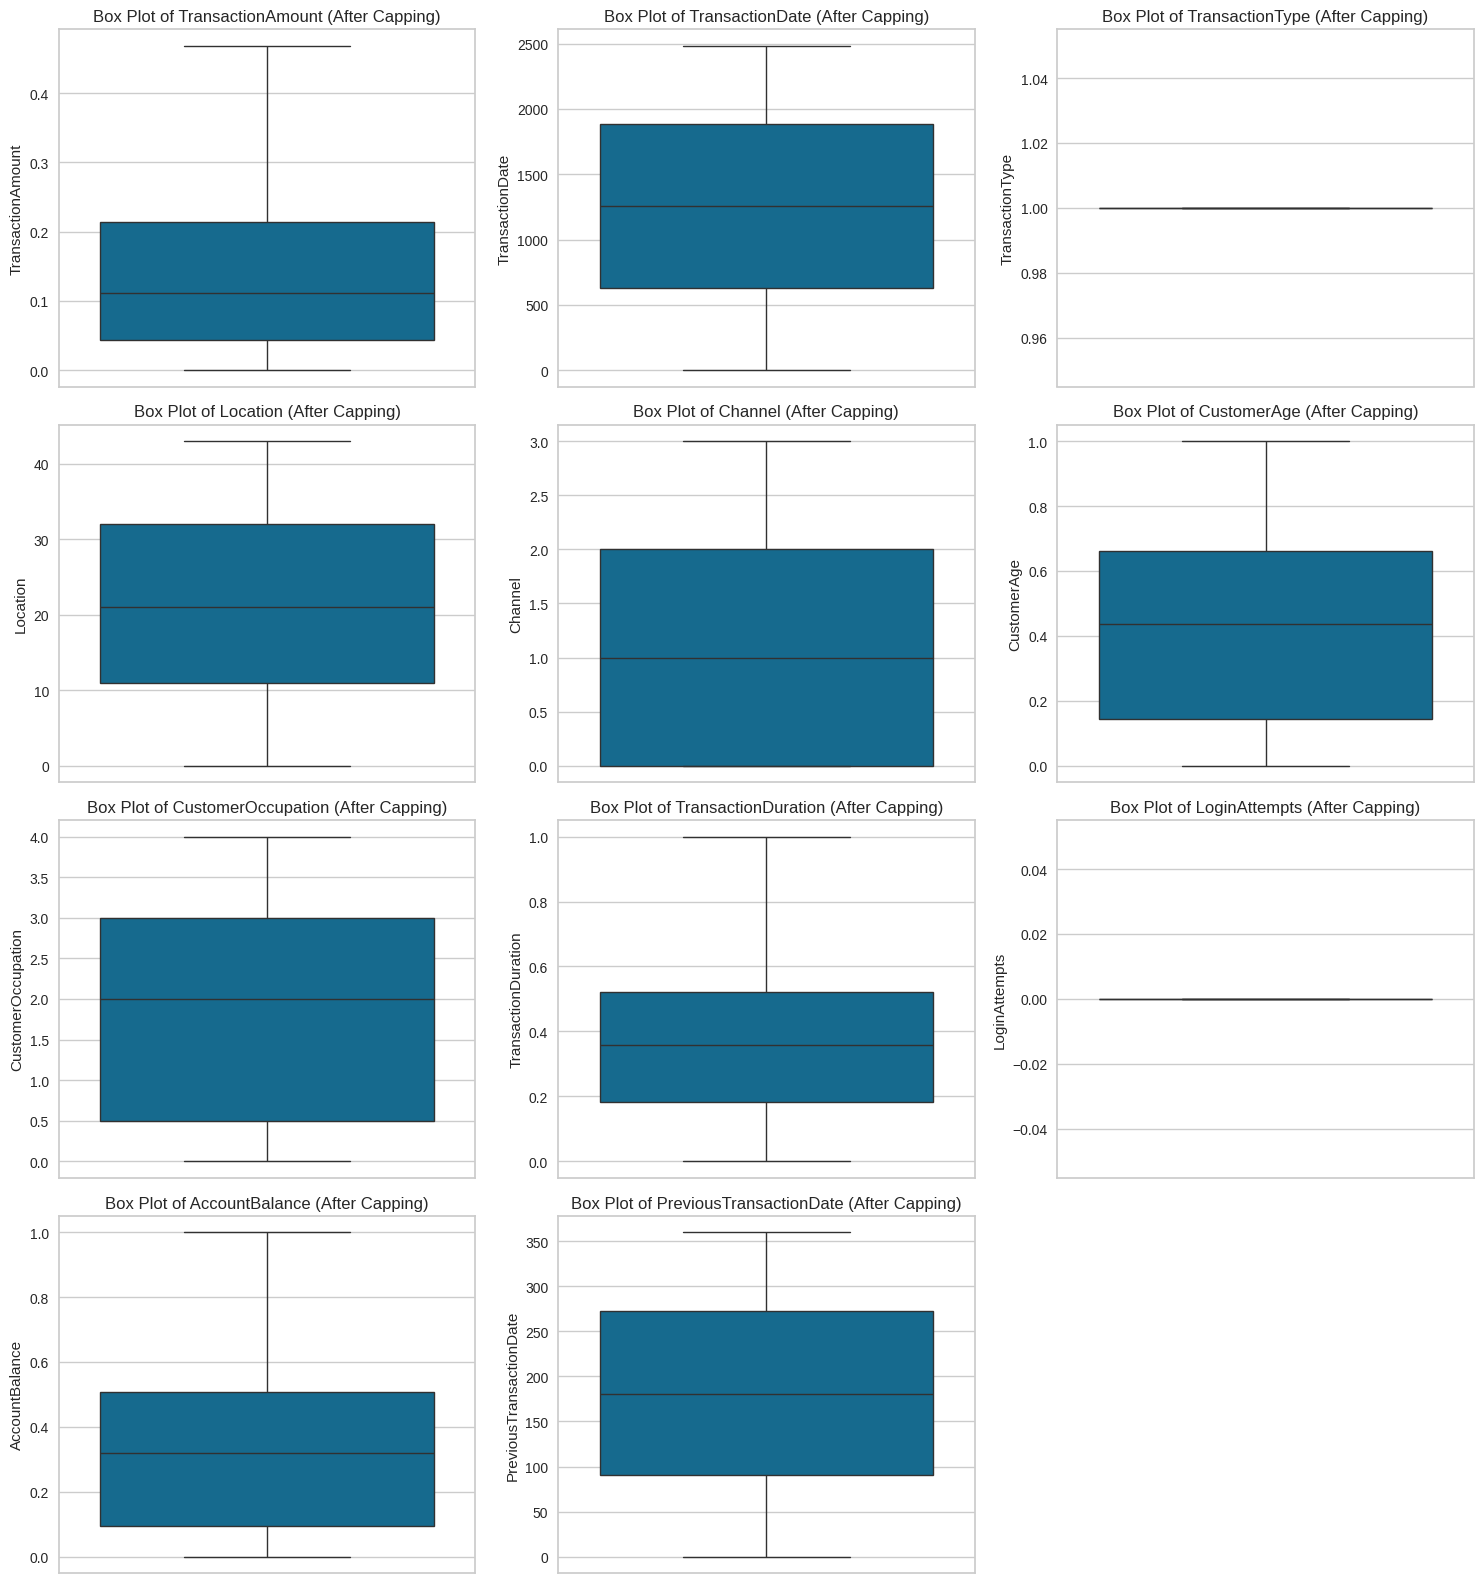

Visualisasi outlier (setelah penanganan) selesai.


In [25]:
# --- Langkah 3: Visualisasi Outlier Menggunakan Box Plot (Setelah Penanganan) ---

print("\n--- Langkah 3: Visualisasi Outlier (Setelah Penanganan) ---")

# Visualisasikan kembali menggunakan DataFrame yang sudah dibersihkan outlier
if not numerical_cols_scaled:
     print("Tidak ada fitur numerik untuk visualisasi setelah penanganan outlier.")
else:
    print(f"Memvisualisasikan outlier setelah penanganan untuk fitur: {numerical_cols_scaled}")
    n_cols = 3
    n_rows = (len(numerical_cols_scaled) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols_scaled):
         if i < len(axes):
            sns.boxplot(y=df_processed_cleaned[col], ax=axes[i])
            axes[i].set_title(f'Box Plot of {col} (After Capping)')
            axes[i].set_ylabel(col)
         else:
            axes[i].axis('off') # Sembunyikan subplot yang kosong

    # Sembunyikan subplot yang tidak digunakan
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    print("Visualisasi outlier (setelah penanganan) selesai.")

In [26]:
# Periksa tipe data di DataFrame yang sudah dibersihkan outlier
print("\nMemeriksa tipe data di df_processed_cleaned:")
print(df_processed_cleaned.info())

# Identifikasi kolom non-numerik
non_numeric_cols = df_processed_cleaned.select_dtypes(exclude=[np.number]).columns.tolist()

if non_numeric_cols:
    print(f"\nKolom non-numerik yang ditemukan: {non_numeric_cols}")
    print("Menghapus kolom non-numerik sebelum visualisasi Elbow dan clustering.")
    # Hapus kolom non-numerik dari DataFrame yang akan digunakan untuk modeling
    df_modeling = df_processed_cleaned.drop(columns=non_numeric_cols)
    print(f"Shape df_modeling setelah menghapus kolom non-numerik: {df_modeling.shape}")
else:
    print("\nTidak ada kolom non-numerik ditemukan di df_processed_cleaned. Siap untuk modeling.")
    df_modeling = df_processed_cleaned.copy() # Buat salinan untuk konsistensi


Memeriksa tipe data di df_processed_cleaned:
<class 'pandas.core.frame.DataFrame'>
Index: 2515 entries, 0 to 2535
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionAmount        2515 non-null   float64
 1   TransactionDate          2515 non-null   int64  
 2   TransactionType          2515 non-null   int64  
 3   Location                 2515 non-null   int64  
 4   Channel                  2515 non-null   int64  
 5   CustomerAge              2515 non-null   float64
 6   CustomerOccupation       2515 non-null   int64  
 7   TransactionDuration      2515 non-null   float64
 8   LoginAttempts            2515 non-null   float64
 9   AccountBalance           2515 non-null   float64
 10  PreviousTransactionDate  2515 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 235.8 KB
None

Tidak ada kolom non-numerik ditemukan di df_processed_cleaned. Siap untuk modeling.


# **4. Membangun Model Clustering**
Membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan.
1. Menggunakan dataframe yang sudah melalui processing
2. Melakukan visualisasi Elbow Method untuk menentukan jumlah cluster terbaik menggunakan `KElbowVisualizer()`.
3. Menggunakan algoritma K-Means Clustering dengan `sklearn.cluster.KMeans()`.
4. Menjalankan code `joblib.dump` untuk menyimpan model yang sudah dibuat.

In [27]:
# Gunakan describe untuk memastikan proses clustering menggunakan dataset hasil preprocessing

print(df_modeling.describe())

       TransactionAmount  TransactionDate  TransactionType     Location  \
count        2515.000000      2515.000000           2515.0  2515.000000   
mean            0.148066      1256.121272              1.0    21.286282   
std             0.130024       725.512424              0.0    12.395592   
min             0.000000         0.000000              1.0     0.000000   
25%             0.043180       628.500000              1.0    11.000000   
50%             0.111087      1256.000000              1.0    21.000000   
75%             0.213326      1884.500000              1.0    32.000000   
max             0.468545      2485.000000              1.0    43.000000   

           Channel  CustomerAge  CustomerOccupation  TransactionDuration  \
count  2515.000000  2515.000000         2515.000000          2515.000000   
mean      1.010736     0.429579            1.530417             0.377697   
std       0.830674     0.286277            1.150287             0.240111   
min       0.000000  


 visualisasi Elbow Method ---


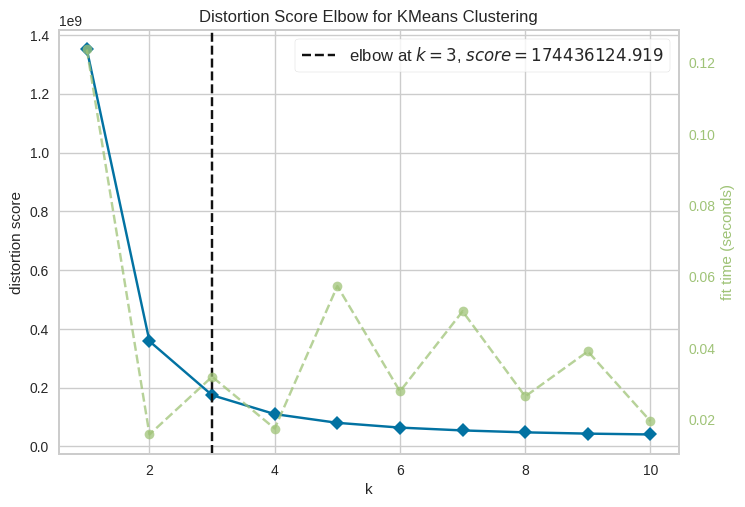

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
# Melakukan visualisasi Elbow Method menggunakan KElbowVisualizer()

print("\n visualisasi Elbow Method ---")
# Inisialisasi model K-Means untuk visualizer.
# Gunakan n_init eksplisit untuk menghindari FutureWarning di sklearn versi baru.
# Membuat objek KMeans
model = KMeans()

# Membuat visualizer Elbow
visualizer = KElbowVisualizer(model, k=(1, 11))  # Uji jumlah cluster dari 1 hingga 10

# Fit visualizer dengan data
visualizer.fit(df_modeling)

# Tampilkan visualisasi
visualizer.show()

In [29]:
k_optimal_chosen = 3
print(f"\nBerdasarkan Elbow Method, nilai k_optimal yang dipilih (contoh) adalah: {k_optimal_chosen}")


Berdasarkan Elbow Method, nilai k_optimal yang dipilih (contoh) adalah: 3


In [30]:
# algoritma K-Means Clustering

# Inisialisasi model K-Means dengan k_optimal yang sudah ditentukan dari Elbow Method.
model_kmeans = KMeans(n_clusters=k_optimal_chosen, random_state=42, n_init=10)

# Latih model K-Means pada DataFrame yang sudah diproses.
print(f"Melatih model K-Means dengan {k_optimal_chosen} cluster...")
model_kmeans.fit(df_modeling)

df_modeling['Cluster'] = model_kmeans.labels_

print("Penambahan label cluster ke DataFrame df_modeling berhasil.")
print("5 baris pertama df_modeling dengan kolom 'Cluster' baru:")
print(df_modeling.head())

print("\nJumlah anggota di setiap cluster:")
print(df_modeling['Cluster'].value_counts().sort_index())

Melatih model K-Means dengan 3 cluster...
Penambahan label cluster ke DataFrame df_modeling berhasil.
5 baris pertama df_modeling dengan kolom 'Cluster' baru:
   TransactionAmount  TransactionDate  TransactionType  Location  Channel  \
0           0.007207              680                1        36        0   
1           0.195940             1178                1        15        0   
2           0.065680             1262                1        23        2   
3           0.096016              818                1        33        2   
4           0.006874             1939                1         1        2   

   CustomerAge  CustomerOccupation  TransactionDuration  LoginAttempts  \
0     0.838710                   0             0.244828            0.0   
1     0.806452                   0             0.451724            0.0   
2     0.016129                   3             0.158621            0.0   
3     0.129032                   3             0.051724            0.0   
4     0.

Jalankan cell code ini untuk menyimpan model kamu.

In [31]:
# Menyimpan model menggunakan joblib

try:
    joblib.dump(model_kmeans, "model_clustering")
    print("✅ Model clustering berhasil disimpan sebagai 'model_clustering")
except Exception as e:
    print(f"❌ Gagal menyimpan model: {e}")

✅ Model clustering berhasil disimpan sebagai 'model_clustering


In [32]:
# Menghitung dan menampilkan nilai Silhouette Score.

if k_optimal_chosen > 1 and len(df_modeling) >= 2:
    try:
        silhouette_avg = silhouette_score(df_modeling, df_modeling['Cluster'])
        print(f"Nilai Silhouette Score: {silhouette_avg:.4f}")
    except Exception as e:
        print(f"Terjadi error saat menghitung Silhouette Score: {e}")
        print("Pastikan data input untuk Silhouette Score valid (tidak ada NaN, dimensi cocok).")
else:
    print("Tidak dapat menghitung Silhouette Score karena k_optimal <= 1 atau jumlah sampel tidak cukup.")

Nilai Silhouette Score: 0.5405



--- Menghitung Silhouette Score untuk Berbagai Nilai K ---
Silhouette Score untuk k=2: 0.6003
Silhouette Score untuk k=3: 0.5405
Silhouette Score untuk k=4: 0.4986
Silhouette Score untuk k=5: 0.4619
Silhouette Score untuk k=6: 0.4314
Silhouette Score untuk k=7: 0.4025
Silhouette Score untuk k=8: 0.3793
Silhouette Score untuk k=9: 0.3564
Silhouette Score untuk k=10: 0.3558


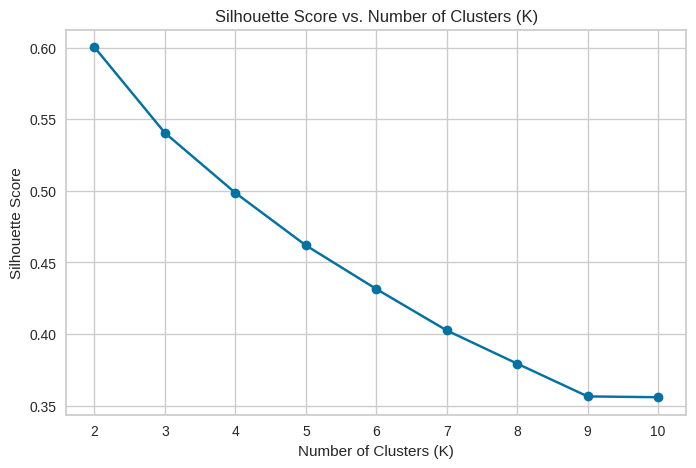


Visualisasi Silhouette Score selesai.

Nilai K dengan Silhouette Score tertinggi adalah: 2


In [44]:
# --- Menghitung dan Menampilkan Silhouette Score untuk Berbagai Nilai K ---

print("\n--- Menghitung Silhouette Score untuk Berbagai Nilai K ---")

# Gunakan df_modeling yang sudah disiapkan
X_modeling = df_modeling # Nama variabel yang lebih standar untuk data input model

# Simpan nilai Silhouette Score untuk setiap k
silhouette_scores = []
# Simpan nilai k yang diuji
k_values = range(2, 11) # Uji dari k=2 hingga k=10 (k=1 tidak bisa dihitung silhouette)

if X_modeling.empty or len(X_modeling) < 2:
    print("Data tidak cukup untuk menghitung Silhouette Score.")
else:
    for k in k_values:
        try:
            # Latih model K-Means untuk nilai k saat ini
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_modeling)
            labels = kmeans.labels_

            # Hitung Silhouette Score
            score = silhouette_score(X_modeling, labels)
            silhouette_scores.append(score)
            print(f"Silhouette Score untuk k={k}: {score:.4f}")

        except Exception as e:
            print(f"Terjadi error saat menghitung Silhouette Score untuk k={k}: {e}")
            silhouette_scores.append(None) # Tambahkan None jika gagal

    # Opsional: Visualisasikan Silhouette Score per K
    if silhouette_scores:
        plt.figure(figsize=(8, 5))
        plt.plot(k_values, silhouette_scores, marker='o')
        plt.title('Silhouette Score vs. Number of Clusters (K)')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Silhouette Score')
        plt.xticks(k_values) # Atur tanda di sumbu x sesuai nilai k
        plt.grid(True)
        plt.show()
        print("\nVisualisasi Silhouette Score selesai.")

        # Temukan k dengan score tertinggi (jika ada score yang valid)
        valid_scores = [(k_values[i], score) for i, score in enumerate(silhouette_scores) if score is not None]
        if valid_scores:
            best_k_silhouette = max(valid_scores, key=lambda item: item[1])[0]
            print(f"\nNilai K dengan Silhouette Score tertinggi adalah: {best_k_silhouette}")
        else:
             print("\nTidak ada Silhouette Score yang valid dihitung.")
    else:
        print("\nTidak ada Silhouette Score yang dihitung.")


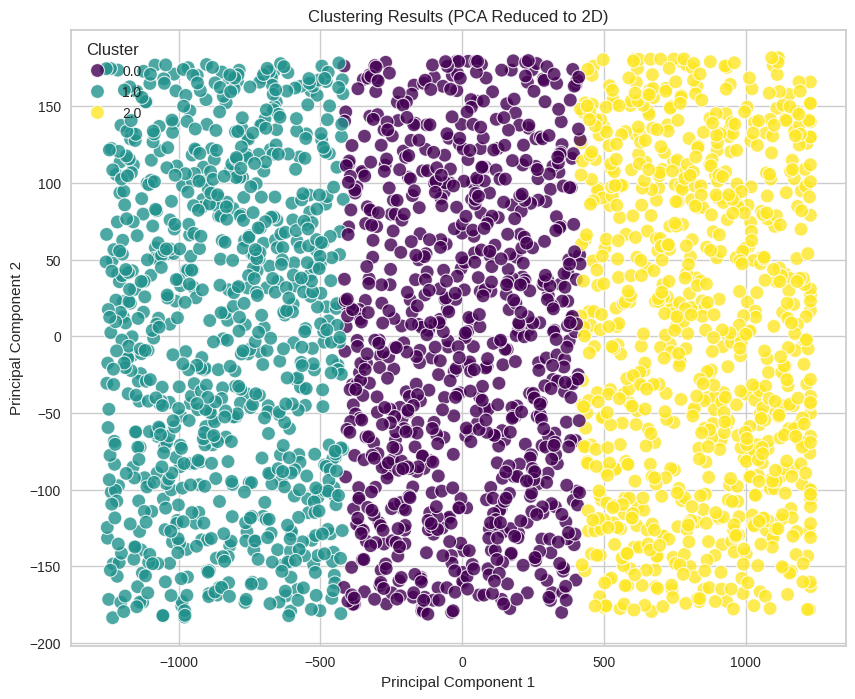

Visualisasi hasil clustering selesai.


In [33]:
# Membuat visualisasi hasil clustering

from sklearn.decomposition import PCA

df_for_pca_viz = df_modeling.copy()

if df_for_pca_viz.empty:
    print("Tidak ada data untuk visualisasi PCA.")
elif df_for_pca_viz.shape[1] < 2:
    print(f"Tidak cukup dimensi ({df_for_pca_viz.shape[1]}) untuk visualisasi PCA 2D.")
else:
    try:
        pca = PCA(n_components=2, random_state=42)
        principal_components = pca.fit_transform(df_for_pca_viz)

        df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
        df_pca['Cluster'] = df_modeling['Cluster']

        plt.figure(figsize=(10, 8))
        sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca,
                        palette='viridis', s=100, alpha=0.8, legend='full')
        plt.title('Clustering Results (PCA Reduced to 2D)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True)
        plt.show()
        print("Visualisasi hasil clustering selesai.")
    except Exception as e:
        print(f"Terjadi error saat membuat visualisasi PCA: {e}")
        print("Pastikan data input untuk PCA valid.")

# **5. Interpretasi Cluster**

In [36]:
# Menampilkan analisis deskriptif minimal mean, min dan max untuk fitur numerik.
# Silakan menambahkan fungsi agregasi lainnya untuk experience lebih baik.

features_for_interpretation = df_modeling.drop(columns=['Cluster']).select_dtypes(include=[np.number]).columns.tolist()

if not features_for_interpretation:
    print("Tidak ada fitur numerik yang tersedia untuk interpretasi.")
else:
    print(f"Fitur yang akan diinterpretasi: {features_for_interpretation}")

    # Agregasi data per cluster untuk mendapatkan mean, min, dan max
    # Menggunakan groupby 'Cluster'
    cluster_summary = df_modeling.groupby('Cluster')[features_for_interpretation].agg(['mean', 'min', 'max']).transpose()

    print("\nAnalisis Deskriptif (Mean, Min, Max) per Cluster untuk Fitur Numerik:")
    print(cluster_summary)

Fitur yang akan diinterpretasi: ['TransactionAmount', 'TransactionDate', 'TransactionType', 'Location', 'Channel', 'CustomerAge', 'CustomerOccupation', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'PreviousTransactionDate']

Analisis Deskriptif (Mean, Min, Max) per Cluster untuk Fitur Numerik:
Cluster                                 0           1            2
TransactionAmount       mean     0.150234    0.144533     0.149437
                        min      0.000031    0.000313     0.000000
                        max      0.468545    0.468545     0.468545
TransactionDate         mean  1255.500000  418.876043  2092.988095
                        min    838.000000    0.000000  1674.000000
                        max   1673.000000  837.000000  2485.000000
TransactionType         mean     1.000000    1.000000     1.000000
                        min      1.000000    1.000000     1.000000
                        max      1.000000    1.000000     1.000000
Location              

## Menjelaskan karakteristik tiap cluster berdasarkan rentangnya.
1. **Cluster 0: (Pelanggan Dewasa, Paling Aktif & Akses Mudah)**:
  - **Rata-rata (177.08) <Fitur>: PreviousTransactionDate**  (dengan batas minimum 0.00 dan batas maksimum 360.00)
  - **Rata-rata (0.446) <Fitur>: CustomerAge** (dengan batas minimum 0.00 dan batas maksimum 1.00), yang merupakan nilai rata-rata tertinggi (relatif paling tua).
  - **Rata-rata (0.157) <Fitur>: TransactionAmount**  (dengan batas minimum ~0.00003 dan batas maksimum 1.00)
  - **Rata-rata (0.381) <Fitur>: TransactionDuration**   (batas min 0.00, maks ~0.997).
  - **Rata-rata (0.333 ) <Fitur>: AccountBalance** (batas min ~0.001, maks ~0.997).
  - **Rata-rata (0.023) <Fitur>: LoginAttempts**  (dengan batas minimum 0.00 dan batas maksimum 360.00)
  - **Analisis:** Cluster ini usia relatif paling tua, dan upaya login paling sedikit. Nilai transaksi dan saldo akunnya moderat. Durasi transaksi mereka juga cukup tinggi. Pelanggan ini tampaknya nyaman dengan platform (login mudah) dan aktif. Usia yang lebih matang dan aktivitas terkini membuat mereka segmen yang penting untuk dijaga. Durasi transaksi yang cukup tinggi mungkin memerlukan perhatian pada efisiensi proses atau jenis transaksi yang mereka lakukan. Sehingga rekomendasi pada cluster ini adalah dengan mempertahankan keterlibatan dengan penawaran yang relevan, permudah transaksi yang mungkin kompleks, tawarkan produk untuk segmen usia matang.

<br><br>
2. **Cluster 1: (Pelanggan Muda, Kurang Aktif & Transaksi Kecil)**:
  - **Rata-rata (184.76) <Fitur>: PreviousTransactionDate**  (dengan batas minimum 0.00 dan batas maksimum 360.00), yang merupakan nilai rata-rata tertinggi (paling lama tidak bertransaksi).
  - **Rata-rata (0.415 ) <Fitur>: CustomerAge**  (batas min 0.00, maks 1.00), yang merupakan terendah (relatif paling muda).
  - **Rata-rata (0.150) <Fitur>: TransactionAmount**  (dengan batas minimum ~0.0003 dan batas maksimum ~0.954), yang merupakan nilai rata-rata terendah.
  - **Rata-rata (0.369 ) <Fitur>: TransactionDuration**  (batas min 0.00, maks ~0.997), yang merupakan terendah.
  - **Rata-rata (0.334) <Fitur>: AccountBalance**(batas min ~0.00006, maks ~0.998).
  - **Rata-rata (0.038) <Fitur>: LoginAttempts** (dengan batas minimum 0.00 dan batas maksimum 1.00), yang merupakan nilai rata-rata tertinggi (lebih sering gagal login atau mencoba berulang kali) dibandingkan cluster lain.
  - **Analisis:** Cluster ini  usia relatif paling muda, nilai transaksi terendah, dan durasi transaksi terpendek. Mereka juga memiliki upaya login tertinggi. Kombinasi usia muda, transaksi cepat, nilai rendah, dan ketidakaktifan adalah profil berisiko. Tingginya upaya login mungkin menandakan adanya friksi atau masalah akses. Sehingga rekomendasi pada cluster ini adalah Kampanye re-engagement yang agresif dengan insentif, perbaikan pada proses login atau UX, penawaran produk entry-level yang sesuai dengan nilai transaksi mereka.

  <br><br>
3. **Cluster 2: (Pelanggan Mapan dengan Transaksi & Saldo Tertinggi)**:
  - **Rata-rata (180.69) <Fitur>: PreviousTransactionDate**  (batas min 0.00, maks 360.00), berada di tengah.
  - **Rata-rata (0.428 ) <Fitur>: CustomerAge**  (batas min 0.00, maks 1.00), berada di tengah..
  - **Rata-rata (0.159) <Fitur>: TransactionAmount** (dengan batas minimum 0.00 dan batas maksimum ~0.954), yang merupakan nilai rata-rata tertinggi meskipun perbedaannya tipis.
  - **Rata-rata (0.383) <Fitur>: TransactionDuration**  (dengan batas minimum 0.00 dan batas maksimum 1.00), yang merupakan tertinggi.
  - **Rata-rata (0.344) <Fitur>: AccountBalance** (dengan batas minimum 0.00 dan batas maksimum 1.00), yang juga merupakan nilai rata-rata tertinggi.
  - **Rata-rata (0.032 ) <Fitur>: LoginAttempts** (batas min 0.00, maks 1.00), berada di tengah.
  - **Analisis:** Cluster ini ditandai dengan nilai transaksi dan saldo akun rata-rata tertinggi. Durasi transaksi mereka juga paling tinggi. Usia dan Recency mereka berada di tengah-tengah dibandingkan dua cluster lainnya. Ini adalah segmen bernilai tinggi dari sisi moneter. Durasi transaksi yang tinggi mungkin sepadan dengan nilai transaksi yang juga tinggi, atau bisa juga menandakan transaksi yang kompleks. Sehingga rekomendasi pada cluster ini adalah fokus pada layanan premium, produk investasi atau pengembangan aset, program loyalitas eksklusif, dan cross-selling produk bernilai tinggi.


  

# **6. Mengeksport Data**

1. Simpan nama kolom hasil clustering dengan nama `Target`.
2. Simpan hasilnya ke dalam file CSV menggunakan function `to_csv()`.

In [37]:
# Pastikan nama kolom clustering sudah diubah menjadi Target

if 'Cluster' in df_modeling.columns:
    df_modeling.rename(columns={'Cluster': 'Target'}, inplace=True)
    print("Kolom 'Cluster' berhasil diubah menjadi 'Target'.")
    print("5 baris pertama df_modeling setelah perubahan nama kolom:")
    print(df_modeling.head())
else:
    print("Kolom 'Cluster' tidak ditemukan di DataFrame. Pastikan langkah clustering sudah berhasil.")


Kolom 'Cluster' berhasil diubah menjadi 'Target'.
5 baris pertama df_modeling setelah perubahan nama kolom:
   TransactionAmount  TransactionDate  TransactionType  Location  Channel  \
0           0.007207              680                1        36        0   
1           0.195940             1178                1        15        0   
2           0.065680             1262                1        23        2   
3           0.096016              818                1        33        2   
4           0.006874             1939                1         1        2   

   CustomerAge  CustomerOccupation  TransactionDuration  LoginAttempts  \
0     0.838710                   0             0.244828            0.0   
1     0.806452                   0             0.451724            0.0   
2     0.016129                   3             0.158621            0.0   
3     0.129032                   3             0.051724            0.0   
4     0.430297                   3             0.648276    

In [38]:
# Simpan Data
# ___.to_csv('data_clustering.csv', index=False)

output_filename = 'data_clustering.csv'
try:
    df_modeling.to_csv(output_filename, index=False)
    print(f"Data hasil clustering berhasil disimpan ke file '{output_filename}'")
except Exception as e:
    print(f"Gagal menyimpan file CSV: {e}")

Data hasil clustering berhasil disimpan ke file 'data_clustering.csv'
